<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/staging/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

In [10]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [11]:
# 前処理をまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右対称にする
    transforms.ColorJitter(), # ランダムに色を変える。
    transforms.RandomRotation(10), # 回転
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.RandomErasing(), # ランダムに領域を消す
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

In [12]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [13]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [14]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [15]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。
# CosineAnnealingWarmRestartsの設定
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=0.)

In [16]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 勾配の初期化
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.5964924562686693, acc: 0.4142674505710602,      val loss: 1.2160826251148797, val acc: 0.5555111765861511
epoch: 1, loss: 1.1927158569801486, acc: 0.5709372758865356,      val loss: 0.961147955431344, val acc: 0.6591453552246094
epoch: 2, loss: 0.9953921261652875, acc: 0.646253228187561,      val loss: 0.8481861849943289, val acc: 0.6985822319984436
epoch: 3, loss: 0.8624894459203353, acc: 0.695497453212738,      val loss: 0.7458499185383891, val acc: 0.7374201416969299
epoch: 4, loss: 0.7710119144930263, acc: 0.7287867665290833,      val loss: 0.6918603738371175, val acc: 0.7614816427230835
epoch: 5, loss: 0.9163704129723654, acc: 0.6742642521858215,      val loss: 0.7667153046344416, val acc: 0.7334265112876892
epoch: 6, loss: 0.8796630254061804, acc: 0.6884996891021729,      val loss: 0.7543577973644573, val acc: 0.7347244024276733
epoch: 7, loss: 0.8377462412520852, acc: 0.7042146325111389,      val loss: 0.724032216845229, val acc: 0.7432108521461487
epoch: 8, lo

In [17]:
labels

tensor([3, 7, 6, 8, 3, 0, 8, 9, 7, 4, 8, 2, 2, 6, 8, 2], device='cuda:0')

In [18]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [19]:
prob = prob_pred[:, 0]

In [20]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([3.8720e-04, 1.0181e-08, 4.3972e-02, 2.8420e-04, 3.0557e-03, 8.9293e-01,
        1.5407e-03, 3.3881e-04, 8.2129e-05, 1.5072e-03, 2.4075e-03, 1.9778e-04,
        3.2702e-05, 2.7697e-04, 2.9017e-03, 9.9626e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [21]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

In [22]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0. 0. 1.]
[0. 1. 1.]
[          inf 8.9293373e-01 1.0181485e-08]


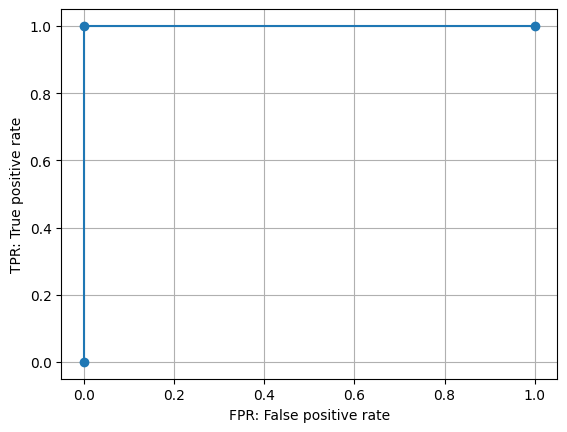

In [23]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [24]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.8164)
tensor(0.8163)
[[4261   57  136   86   57   26   22   41  212  102]
 [  59 4484   20   28    9    8   22   11   83  276]
 [ 226   18 3714  226  269  163  202  104   53   25]
 [  84   22  230 3377  179  680  233  110   41   44]
 [  69    6  223  198 4007  106  164  189   26   12]
 [  33    8  193  657  167 3595   97  203   23   24]
 [  23   14  191  203  140   96 4271   22   19   21]
 [  47    7  100  154  216  162   24 4241   22   27]
 [ 186   87   37   36   14   12   21   12 4516   79]
 [ 100  294   26   44   15   22   25   41   80 4353]]
[[845  13  35  10  17   1   4   7  40  28]
 [ 16 900   3   4   0   2   4   2  16  53]
 [ 48   2 730  47  56  37  48  19   4   9]
 [ 20   4  42 652  45 152  44  21  11   9]
 [ 16   2  42  34 818  19  29  36   4   0]
 [ 15   2  26 147  39 723  12  31   3   2]
 [  8   3  33  45  22  18 862   2   4   3]
 [ 19   1  26  29  28  32   1 857   2   5]
 [ 46  13   7  10   2   5   2   1 895  19]
 [ 25  54   4   7   2   2   3   4  18 881]]
[0.8522 

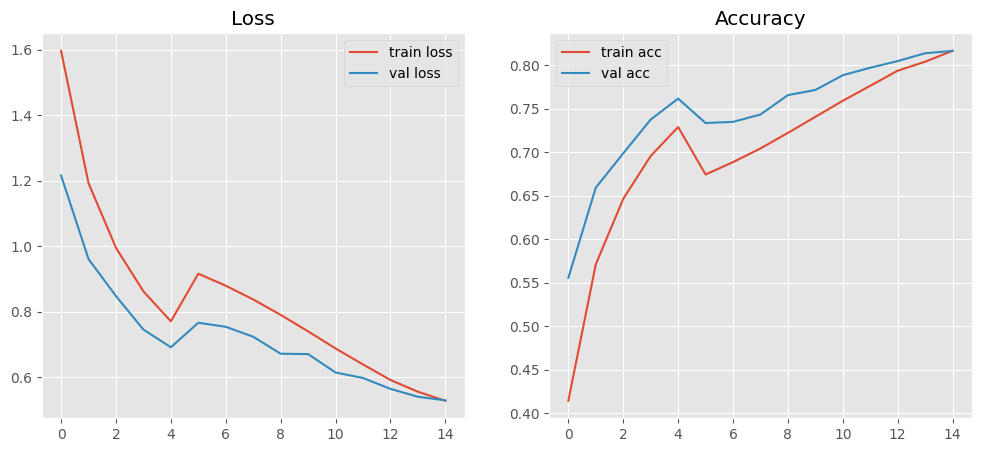

In [25]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [26]:
print(accs)
print(val_accs)

[tensor(0.4143), tensor(0.5709), tensor(0.6463), tensor(0.6955), tensor(0.7288), tensor(0.6743), tensor(0.6885), tensor(0.7042), tensor(0.7221), tensor(0.7405), tensor(0.7590), tensor(0.7762), tensor(0.7935), tensor(0.8039), tensor(0.8164)]
[tensor(0.5555), tensor(0.6591), tensor(0.6986), tensor(0.7374), tensor(0.7615), tensor(0.7334), tensor(0.7347), tensor(0.7432), tensor(0.7655), tensor(0.7714), tensor(0.7883), tensor(0.7969), tensor(0.8046), tensor(0.8136), tensor(0.8163)]


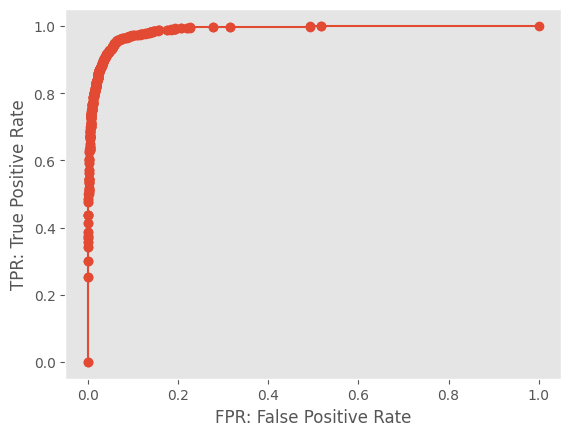

In [27]:
# y_val_true はラベル（0 or 1）を含むリスト
y_val_true = torch.tensor(y_val_true)

# val_output に softmax を適用
val_output_tensor = torch.cat([model(val_imgs.to(device)) for val_imgs, _ in validation_dataloader])
val_prob_pred = torch.softmax(val_output_tensor, dim=1)

# クラス0の確率値を取得
prob = val_prob_pred[:, 0].cpu().detach().numpy()

# 0/1 ラベルの取得
one_zero_labels = torch.where(y_val_true == 0, 1, 0).cpu().detach().numpy()

# ROC曲線の計算
fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

# グラフ描画
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
plt.grid()
plt.show()


ROC AUC Score: 0.9865
ROC AUC Score: 0.9949
ROC AUC Score: 0.9686
ROC AUC Score: 0.9521
ROC AUC Score: 0.9812
ROC AUC Score: 0.9694
ROC AUC Score: 0.9910
ROC AUC Score: 0.9890
ROC AUC Score: 0.9940
ROC AUC Score: 0.9927


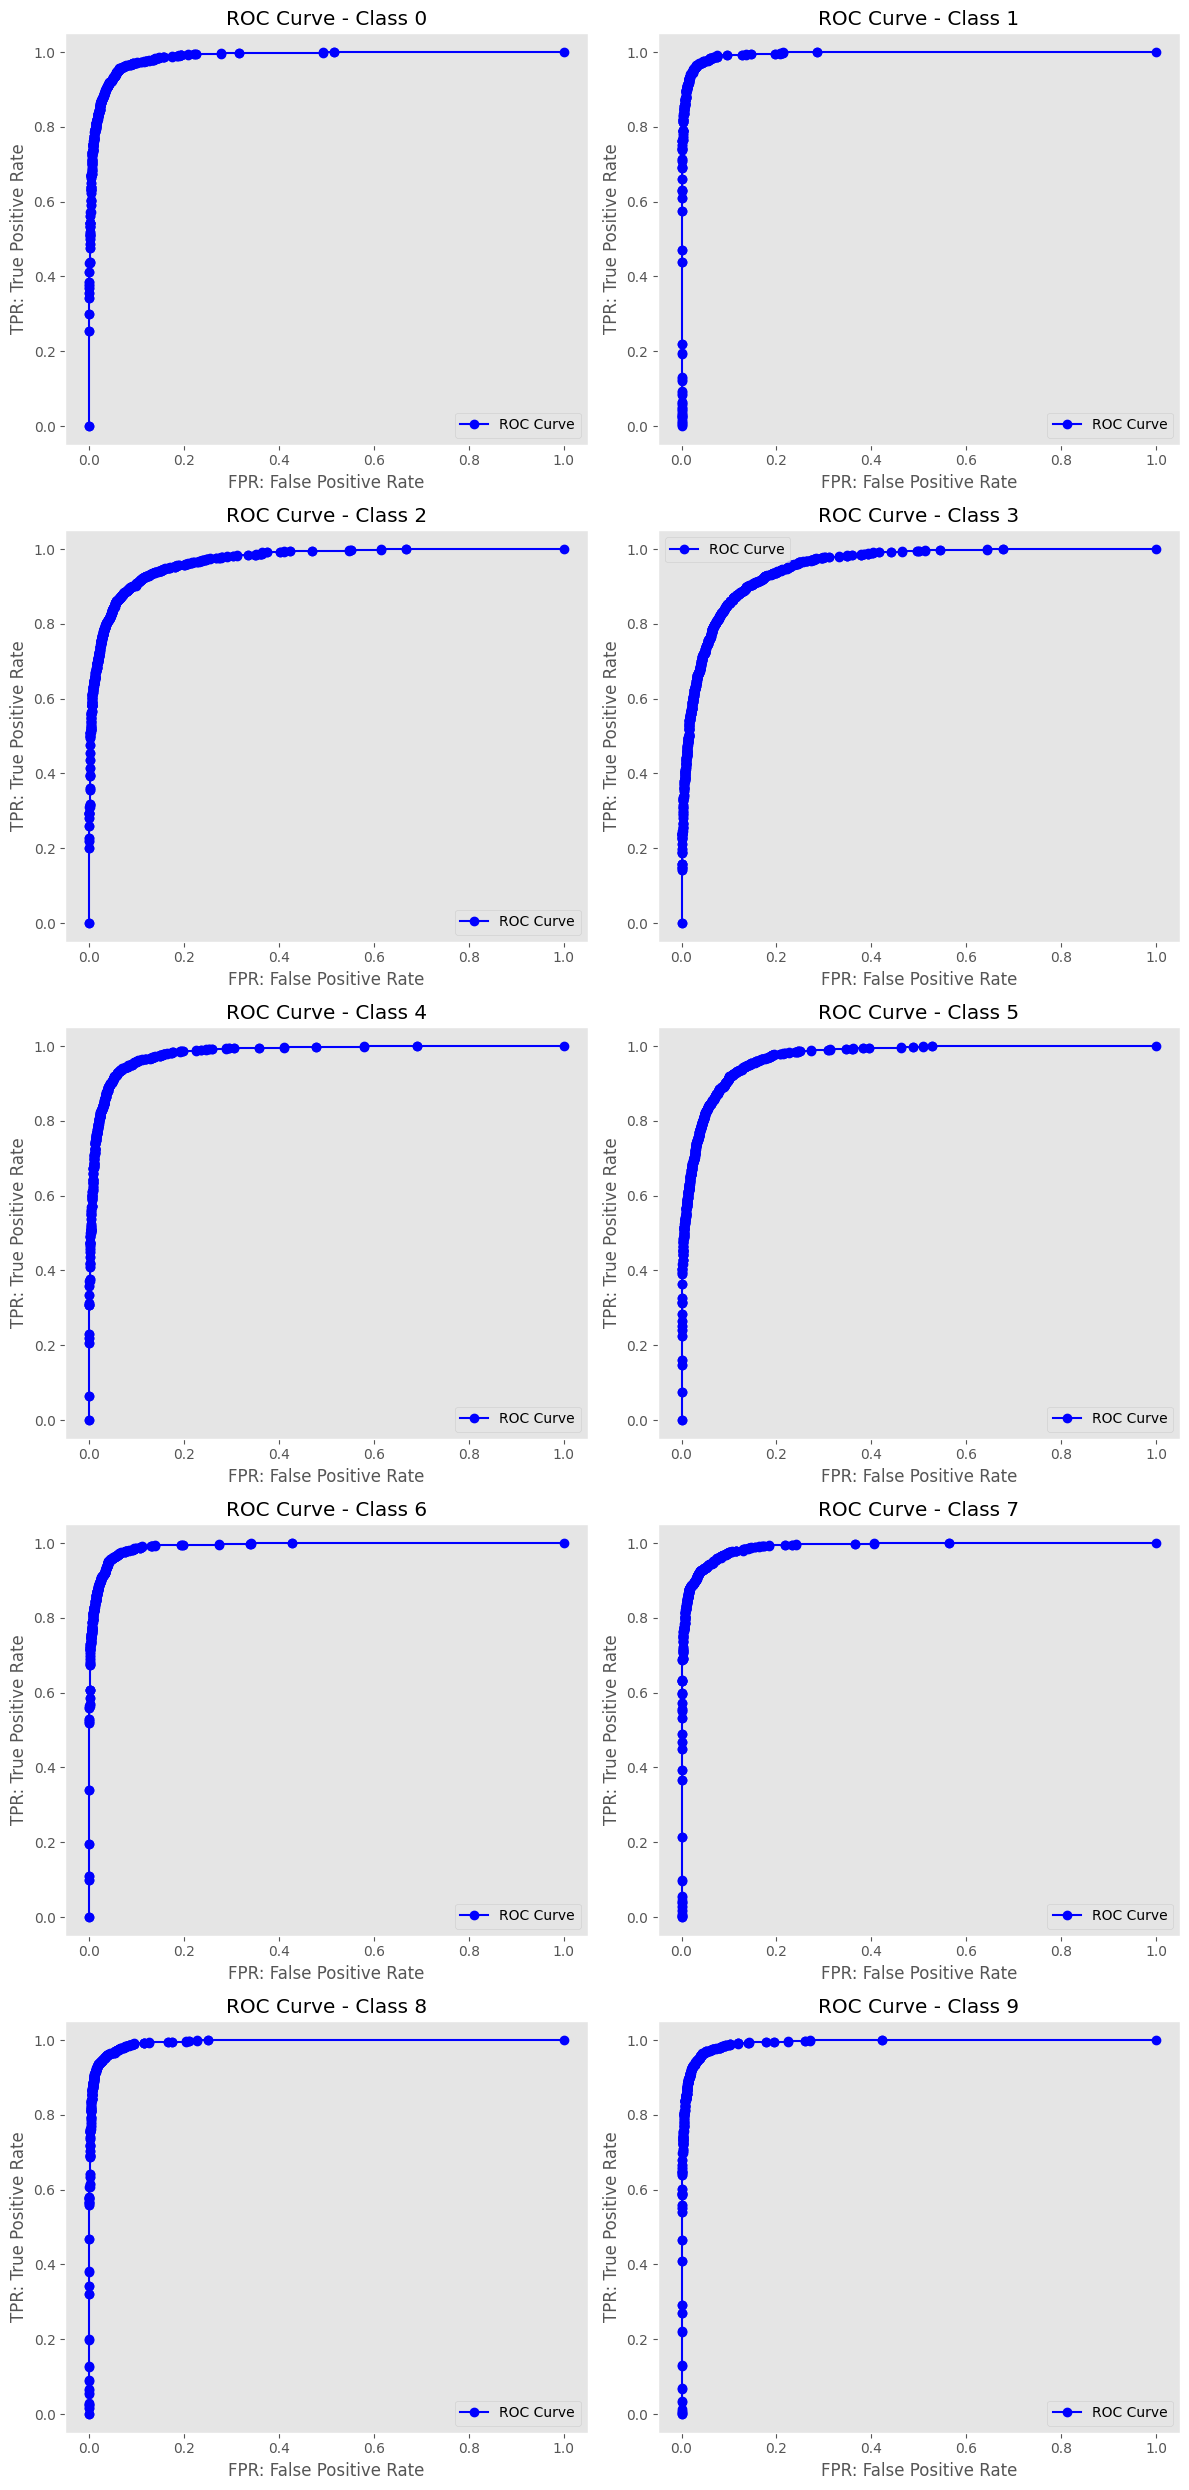

In [28]:
def make_roc_curve():
    fig, axes = plt.subplots(5, 2, figsize=(12, 25))  # 5行2列のサブプロット

    for n in range(10):

        # クラス0の確率値を取得
        prob = val_prob_pred[:, n].cpu().detach().numpy()

        # 0/1 ラベルの取得
        one_zero_labels = torch.where(y_val_true == n, 1, 0).cpu().detach().numpy()

        # ROC曲線の計算
        fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

        # auc算出
        auc_score = roc_auc_score(one_zero_labels, prob)
        print(f"ROC AUC Score: {auc_score:.4f}")

        # 行インデックスと列インデックスの計算
        row_idx = n // 2  # 行インデックス
        col_idx = n % 2   # 列インデックス

        # グラフ描画
        axes[row_idx, col_idx].plot(fpr, tpr, marker='o', color='b', label="ROC Curve")
        axes[row_idx, col_idx].set_xlabel('FPR: False Positive Rate')
        axes[row_idx, col_idx].set_ylabel('TPR: True Positive Rate')
        axes[row_idx, col_idx].set_title(f'ROC Curve - Class {n}')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].grid()
    plt.tight_layout()
    plt.show()

make_roc_curve()